In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
#import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.model_selection
#import sklearn.cross_validation as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

import random
import pickle

In [2]:
original_data= pd.read_csv('./adult_dataset_training.csv', index_col=0)

In [3]:
original_data.head()

age         workclass  fnlwgt education  educational-num  \
26779   74  Self-emp-not-inc  119129   HS-grad                9   
28736   56           Private   98809   7th-8th                4   
19225   17         Local-gov  182070      11th                7   
36240   45           Private  175262       9th                5   
11076   30           Private  224462      11th                7   

           marital-status         occupation relationship                race  \
26779  Married-civ-spouse              Sales      Husband               White   
28736  Married-civ-spouse  Machine-op-inspct         Wife               White   
19225       Never-married      Other-service    Own-child               White   
36240  Married-civ-spouse  Handlers-cleaners      Husband  Asian-Pac-Islander   
11076  Married-civ-spouse   Transport-moving      Husband               White   

       gender  capital-gain  capital-loss  hours-per-week native-country  \
26779    Male             0          2149              20  United-States   
28736  Female          5013             0              45  United-States   
19225  Female             0             0              16  United-States   
36240    Male             0             0              40          India   
11076    Male             0             0              50  United-States   

      income  
26779  <=50K  
28736  <=50K  
19225  <=50K  
36240  <=50K  
11076  <=50K

In [4]:
#Fucntion to encode the categorical data
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

In [5]:
#Encode categorical data like marital status, occupation and relationship as integers
encoded_data, encoders = number_encode_features(original_data)

In [6]:
#Train-validation split
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(encoded_data.iloc[:, :-1], encoded_data["income"], train_size=0.8)

In [7]:
split_data = {"X_train": X_train,
              "X_test": X_test,
              "y_train": y_train,
              "y_test": y_test}

In [8]:
with open("split_data.pkl", "wb") as f:
    pickle.dump(split_data, f)

# Load data, fit model

In [9]:
original_data= pd.read_csv('./adult_dataset_training.csv', index_col=0)

In [10]:
with open("split_data.pkl", "rb") as f:
    split_data = pickle.load(f)

In [11]:
X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']

In [12]:
#scaling feature variables
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype(np.float64)), columns=X_train.columns)
X_test = scaler.transform(X_test.astype(np.float64))

/home/ozwald/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 score: 0.529607


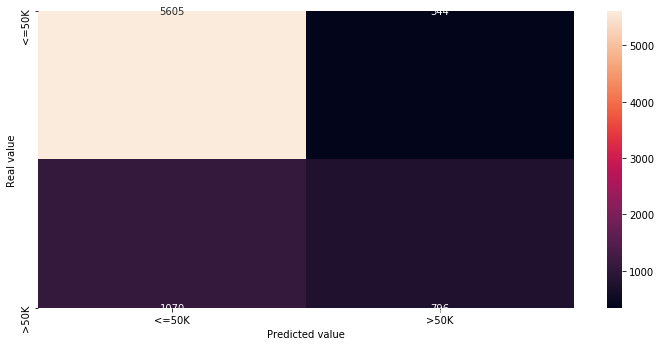

In [13]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
y_proba = cls.predict_proba(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["income"].classes_, yticklabels=encoders["income"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))

In [172]:
print ("Accuracy score: %f" % skl.metrics.accuracy_score(y_test, y_pred))
print ("Precision score: %f" % skl.metrics.precision_score(y_test, y_pred))
print ("Recall score: %f" % skl.metrics.recall_score(y_test, y_pred))

Accuracy score: 0.819066
Precision score: 0.698246
Recall score: 0.426581


In [80]:
test_data = original_data.loc[y_test.index,:]
#test_data['score'] = np.asarray([x[1] for x in y_proba])
test_data['score'] = y_pred
test_data['label_value'] = np.where(test_data['income'] == '>50K', 1, 0)

In [81]:
test_data.head()

age  workclass  fnlwgt     education  educational-num  \
9739    19    Private  160120  Some-college               10   
2847    39    Private  186934       HS-grad                9   
6114    58    Private  186121     Bachelors               13   
16691   41  Local-gov   42346  Some-college               10   
21026   47          ?  224108       HS-grad                9   

           marital-status       occupation   relationship                race  \
9739        Never-married  Exec-managerial      Own-child  Asian-Pac-Islander   
2847   Married-civ-spouse     Craft-repair        Husband               White   
6114             Divorced  Exec-managerial  Not-in-family               White   
16691            Divorced    Other-service  Not-in-family               Black   
21026             Widowed                ?      Unmarried               White   

       gender  capital-gain  capital-loss  hours-per-week native-country  \
9739     Male          2597             0              40              ?   
2847     Male             0             0              38  United-States   
6114     Male             0             0              40  United-States   
16691  Female             0             0              24  United-States   
21026  Female             0             0              40  United-States   

      income  score  label_value  
9739   <=50K      0            0  
2847   <=50K      0            0  
6114   <=50K      1            0  
16691  <=50K      0            0  
21026  <=50K      0            0

In [40]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot
from aequitas.preprocessing import preprocess_input_df

In [18]:
df, _ = preprocess_input_df(test_data)
df.head()

age  workclass               fnlwgt     education  \
9739   17.00-28.00    Private  117646.00-178644.00  Some-college   
2847   37.00-48.00    Private  178644.00-236939.00       HS-grad   
6114   48.00-90.00    Private  178644.00-236939.00     Bachelors   
16691  37.00-48.00  Local-gov   13769.00-117646.00  Some-college   
21026  37.00-48.00          ?  178644.00-236939.00       HS-grad   

      educational-num      marital-status       occupation   relationship  \
9739       9.00-10.00       Never-married  Exec-managerial      Own-child   
2847        1.00-9.00  Married-civ-spouse     Craft-repair        Husband   
6114      12.00-16.00            Divorced  Exec-managerial  Not-in-family   
16691      9.00-10.00            Divorced    Other-service  Not-in-family   
21026       1.00-9.00             Widowed                ?      Unmarried   

                     race  gender   capital-gain  capital-loss hours-per-week  \
9739   Asian-Pac-Islander    Male  0.00-99999.00  0.00-3900.00     1.00-40.00   
2847                White    Male  0.00-99999.00  0.00-3900.00     1.00-40.00   
6114                White    Male  0.00-99999.00  0.00-3900.00     1.00-40.00   
16691               Black  Female  0.00-99999.00  0.00-3900.00     1.00-40.00   
21026               White  Female  0.00-99999.00  0.00-3900.00     1.00-40.00   

      native-country income  score  label_value  
9739               ?  <=50K      0            0  
2847   United-States  <=50K      0            0  
6114   United-States  <=50K      1            0  
16691  United-States  <=50K      0            0  
21026  United-States  <=50K      0            0

In [19]:
g = Group()
xtab, _ = g.get_crosstabs(test_data)
xtab

model_id, score_thresholds 1 {'rank_abs': [1140]}


model_id score_threshold     k  attribute_name attribute_value       tpr  \
0           1      binary 0/1  1140             age     17.00-28.00  0.233333   
1           1      binary 0/1  1140             age     28.00-37.00  0.296629   
2           1      binary 0/1  1140             age     37.00-48.00  0.440725   
3           1      binary 0/1  1140             age     48.00-90.00  0.532573   
4           1      binary 0/1  1140       workclass               ?  0.413043   
..        ...             ...   ...             ...             ...       ...   
115         1      binary 0/1  1140  native-country   United-States  0.429234   
116         1      binary 0/1  1140  native-country         Vietnam  0.000000   
117         1      binary 0/1  1140  native-country      Yugoslavia  0.000000   
118         1      binary 0/1  1140          income           <=50K       NaN   
119         1      binary 0/1  1140          income            >50K  0.426581   

          tnr       for       fdr       fpr  ...     pprev   fp    fn    tn  \
0    0.994581  0.033046  0.343750  0.005419  ...  0.015094   11    69  2019   
1    0.971871  0.184661  0.232558  0.028129  ...  0.092126   40   313  1382   
2    0.902592  0.258710  0.281818  0.097408  ...  0.221106  124   401  1149   
3    0.861928  0.213860  0.340726  0.138072  ...  0.269859  169   287  1055   
4    0.965879  0.068354  0.406250  0.034121  ...  0.074941   13    27   368   
..        ...       ...       ...       ...  ...       ...  ...   ...   ...   
115  0.941422  0.165378  0.294566  0.058578  ...  0.149879  309   984  4966   
116  1.000000  0.066667       NaN  0.000000  ...  0.000000    0     1    14   
117  1.000000  0.428571       NaN  0.000000  ...  0.000000    0     3     4   
118  0.942175  0.000000  1.000000  0.057825  ...  0.057825  344     0  5605   
119       NaN  1.000000  0.000000       NaN  ...  0.426581    0  1070     0   

      tp  group_label_pos  group_label_neg  group_size  total_entities  \
0     21               90             2030        2120            7815   
1    132              445             1422        1867            7815   
2    316              717             1273        1990            7815   
3    327              614             1224        1838            7815   
4     19               46              381         427            7815   
..   ...              ...              ...         ...             ...   
115  740             1724             5275        6999            7815   
116    0                1               14          15            7815   
117    0                3                4           7            7815   
118    0                0             5949        5949            7815   
119  796             1866                0        1866            7815   

         prev  
0    0.042453  
1    0.238350  
2    0.360302  
3    0.334059  
4    0.107728  
..        ...  
115  0.246321  
116  0.066667  
117  0.428571  
118  0.000000  
119  1.000000  

[120 rows x 26 columns]

In [73]:
b = Bias()
bdf = b.get_disparity_major_group(xtab, original_df=test_data, alpha=0.05, mask_significance=False)
df_bias = bdf
df_bias[df_bias['attribute_name']=='age'][['attribute_value', 'fnr', 'precision', 'fnr_disparity', 'precision_disparity']]

get_disparity_major_group()


attribute_value       fnr  precision  fnr_disparity  precision_disparity
0     17.00-28.00  0.766667   0.656250       1.000000             1.000000
1     28.00-37.00  0.703371   0.767442       0.917440             1.169435
2     37.00-48.00  0.559275   0.718182       0.729489             1.094372
3     48.00-90.00  0.467427   0.659274       0.609687             1.004608

In [74]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
fdf

model_id score_threshold     k  attribute_name attribute_value       tpr  \
0           1      binary 0/1  1140             age     17.00-28.00  0.233333   
1           1      binary 0/1  1140             age     28.00-37.00  0.296629   
2           1      binary 0/1  1140             age     37.00-48.00  0.440725   
3           1      binary 0/1  1140             age     48.00-90.00  0.532573   
4           1      binary 0/1  1140       workclass               ?  0.413043   
..        ...             ...   ...             ...             ...       ...   
115         1      binary 0/1  1140  native-country   United-States  0.429234   
116         1      binary 0/1  1140  native-country         Vietnam  0.000000   
117         1      binary 0/1  1140  native-country      Yugoslavia  0.000000   
118         1      binary 0/1  1140          income           <=50K       NaN   
119         1      binary 0/1  1140          income            >50K  0.426581   

          tnr       for       fdr       fpr  ...  FNR Parity  TPR Parity  \
0    0.994581  0.033046  0.343750  0.005419  ...        True        True   
1    0.971871  0.184661  0.232558  0.028129  ...        True       False   
2    0.902592  0.258710  0.281818  0.097408  ...       False       False   
3    0.861928  0.213860  0.340726  0.138072  ...       False       False   
4    0.965879  0.068354  0.406250  0.034121  ...        True        True   
..        ...       ...       ...       ...  ...         ...         ...   
115  0.941422  0.165378  0.294566  0.058578  ...        True        True   
116  1.000000  0.066667       NaN  0.000000  ...       False       False   
117  1.000000  0.428571       NaN  0.000000  ...       False       False   
118  0.942175  0.000000  1.000000  0.057825  ...         NaN         NaN   
119       NaN  1.000000  0.000000       NaN  ...         NaN         NaN   

     TNR Parity  NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  \
0          True        True              True          True           True   
1          True        True              True         False          False   
2          True       False              True         False          False   
3          True        True              True         False          False   
4          True        True              True         False          False   
..          ...         ...               ...           ...            ...   
115        True        True              True          True           True   
116        True        True               NaN         False          False   
117        True       False               NaN         False          False   
118        True        True               NaN          True            NaN   
119         NaN       False             False         False          False   

     Equalized Odds  Unsupervised Fairness  Supervised Fairness  
0              True                   True                 True  
1             False                  False                False  
2             False                  False                False  
3             False                  False                False  
4              True                  False                False  
..              ...                    ...                  ...  
115            True                   True                 True  
116           False                  False                False  
117           False                  False                False  
118           False                   True                False  
119             NaN                  False                False  

[120 rows x 62 columns]

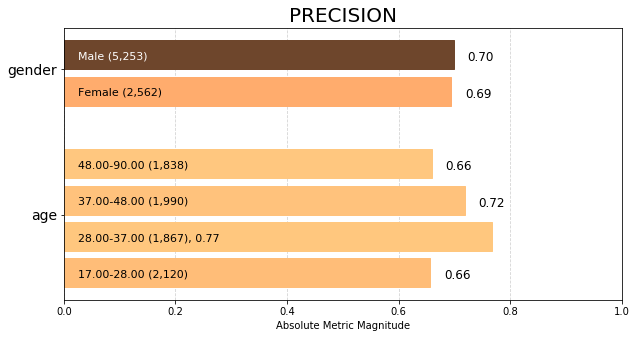

In [54]:
aqp = Plot()
aqp.plot_group_metric(xtab[(xtab['attribute_name'] == 'age') | (xtab['attribute_name'] == 'gender')], 'precision')

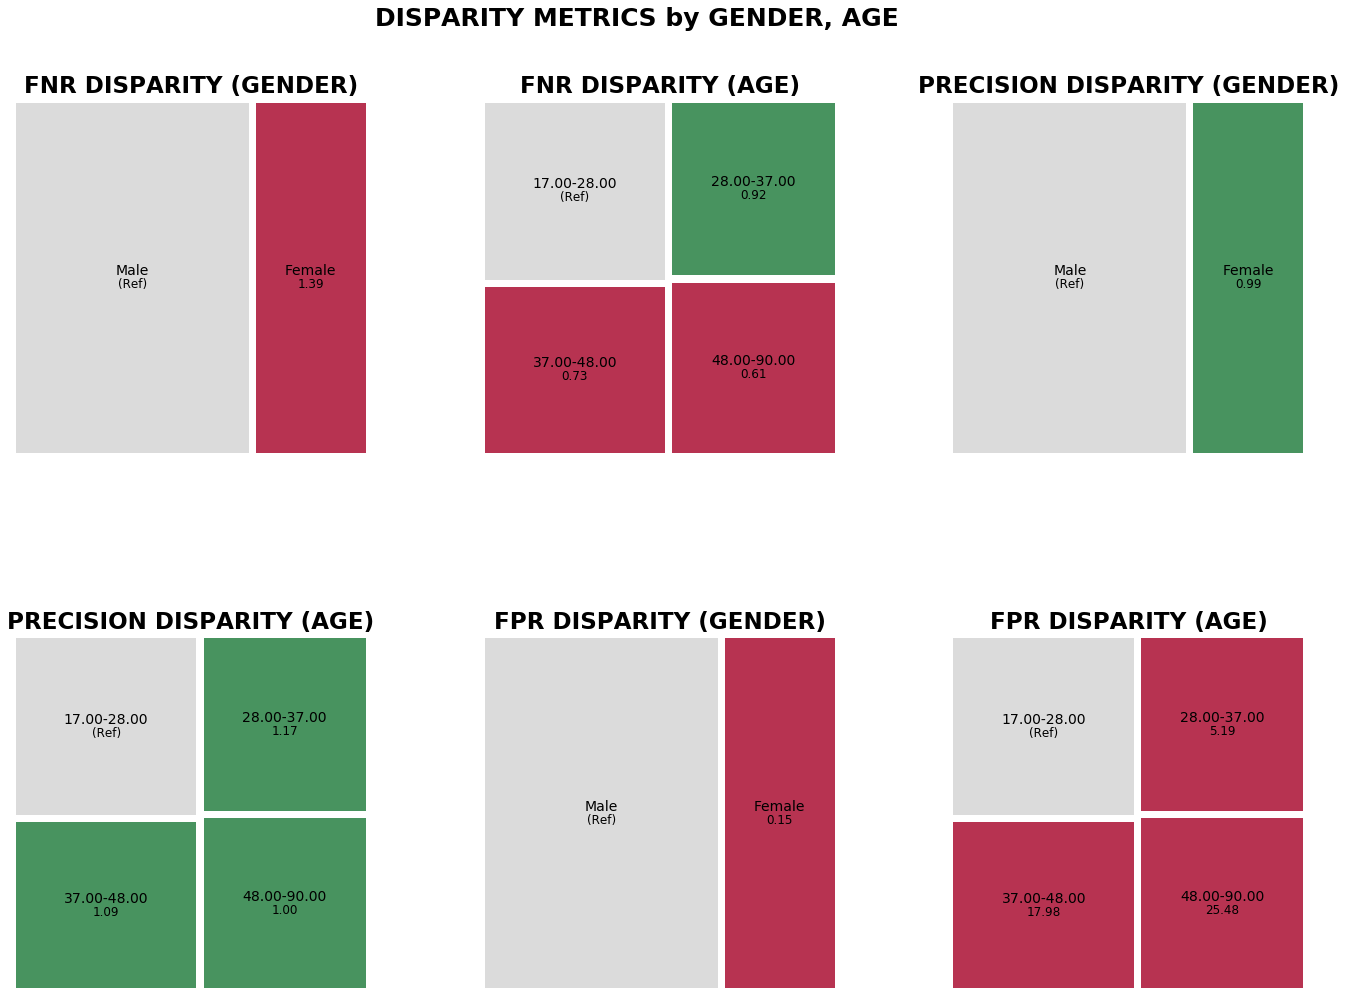

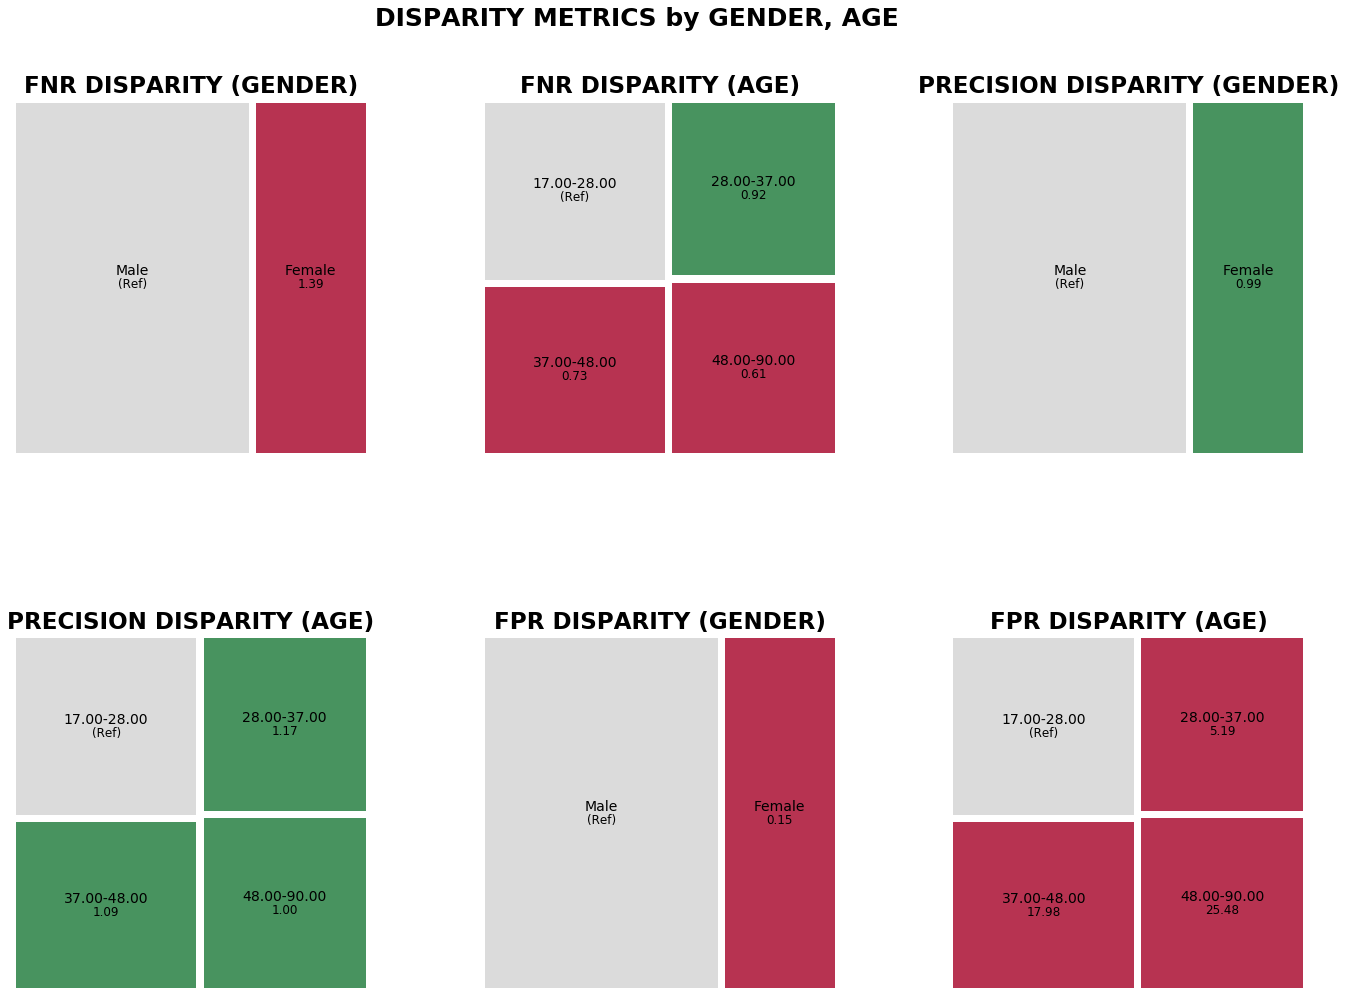

In [77]:
aqp.plot_fairness_disparity_all(fdf, attributes = ['gender','age'],metrics=['fnr','precision','fpr'])

In [20]:
xtab['percent_label_pos'] = (xtab['group_label_pos'] / xtab['group_size']) * 100.0

In [21]:
xtab[xtab['attribute_name'] == 'age']

model_id score_threshold     k attribute_name attribute_value       tpr  \
0         1      binary 0/1  1140            age     17.00-28.00  0.233333   
1         1      binary 0/1  1140            age     28.00-37.00  0.296629   
2         1      binary 0/1  1140            age     37.00-48.00  0.440725   
3         1      binary 0/1  1140            age     48.00-90.00  0.532573   

        tnr       for       fdr       fpr  ...   fp   fn    tn   tp  \
0  0.994581  0.033046  0.343750  0.005419  ...   11   69  2019   21   
1  0.971871  0.184661  0.232558  0.028129  ...   40  313  1382  132   
2  0.902592  0.258710  0.281818  0.097408  ...  124  401  1149  316   
3  0.861928  0.213860  0.340726  0.138072  ...  169  287  1055  327   

   group_label_pos  group_label_neg  group_size  total_entities      prev  \
0               90             2030        2120            7815  0.042453   
1              445             1422        1867            7815  0.238350   
2              717             1273        1990            7815  0.360302   
3              614             1224        1838            7815  0.334059   

   percent_label_pos  
0           4.245283  
1          23.835029  
2          36.030151  
3          33.405876  

[4 rows x 27 columns]

In [22]:
list(xtab)

['model_id',
 'score_threshold',
 'k',
 'attribute_name',
 'attribute_value',
 'tpr',
 'tnr',
 'for',
 'fdr',
 'fpr',
 'fnr',
 'npv',
 'precision',
 'pp',
 'pn',
 'ppr',
 'pprev',
 'fp',
 'fn',
 'tn',
 'tp',
 'group_label_pos',
 'group_label_neg',
 'group_size',
 'total_entities',
 'prev',
 'percent_label_pos']

In [23]:
def map_attribute(aoi, list_of_fields, xtab):
    subset = xtab[xtab['attribute_name'] == aoi]
    return subset[list_of_fields]

## Investigating loans scenario

In [24]:
loan_fields = ['attribute_value', 'fp', 'fn', 'tp', 'fnr','for','fpr','precision', 'group_size','group_label_pos', 'percent_label_pos']

map_attribute('age',loan_fields, xtab)

attribute_value   fp   fn   tp       fnr       for       fpr  precision  \
0     17.00-28.00   11   69   21  0.766667  0.033046  0.005419   0.656250   
1     28.00-37.00   40  313  132  0.703371  0.184661  0.028129   0.767442   
2     37.00-48.00  124  401  316  0.559275  0.258710  0.097408   0.718182   
3     48.00-90.00  169  287  327  0.467427  0.213860  0.138072   0.659274   

   group_size  group_label_pos  percent_label_pos  
0        2120               90           4.245283  
1        1867              445          23.835029  
2        1990              717          36.030151  
3        1838              614          33.405876

In [25]:
map_attribute('race',loan_fields, xtab)

attribute_value   fp   fn   tp       fnr       for       fpr  \
65  Amer-Indian-Eskimo    0    4    1  0.800000  0.047059  0.000000   
66  Asian-Pac-Islander   10   39   24  0.619048  0.197970  0.059524   
67               Black   13   51   26  0.662338  0.077156  0.020867   
68               Other    0    3    3  0.500000  0.053571  0.000000   
69               White  321  973  742  0.567347  0.171424  0.063893   

    precision  group_size  group_label_pos  percent_label_pos  
65   1.000000          86                5           5.813953  
66   0.705882         231               63          27.272727  
67   0.666667         700               77          11.000000  
68   1.000000          59                6          10.169492  
69   0.698024        6739             1715          25.448880

In [26]:
map_attribute('gender',loan_fields, xtab)

attribute_value   fp   fn   tp       fnr       for       fpr  precision  \
70          Female   29  203   66  0.754647  0.082286  0.012647   0.694737   
71            Male  315  867  730  0.542893  0.206036  0.086160   0.698565   

    group_size  group_label_pos  percent_label_pos  
70        2562              269          10.499610  
71        5253             1597          30.401675

In [32]:
map_attribute('relationship',loan_fields,xtab)

attribute_value   fp   fn   tp       fnr       for       fpr  precision  \
59         Husband  218  787  653  0.546528  0.339370  0.124571   0.749713   
60   Not-in-family  103   96   89  0.518919  0.052146  0.055736   0.463542   
61  Other-relative    3    8    2  0.800000  0.033755  0.012931   0.400000   
62       Own-child    8   11    5  0.687500  0.009346  0.006814   0.384615   
63       Unmarried    9   32   20  0.615385  0.041290  0.011968   0.689655   
64            Wife    3  136   27  0.834356  0.417178  0.015544   0.900000   

    group_size  group_label_pos  percent_label_pos  
59        3190             1440          45.141066  
60        2033              185           9.099852  
61         242               10           4.132231  
62        1190               16           1.344538  
63         804               52           6.467662  
64         356              163          45.786517

In [27]:
stats = map_attribute('marital-status',loan_fields, xtab)
print(np.std(stats['fnr']), np.std(stats['precision']))
stats

0.16243382199231934 0.1292454571761776


attribute_value   fp   fn   tp       fnr       for       fpr  \
37               Divorced   87   44   62  0.415094  0.047983  0.090625   
38      Married-AF-spouse    0    3    0  1.000000  0.500000  0.000000   
39     Married-civ-spouse  223  931  682  0.577185  0.342531  0.110945   
40  Married-spouse-absent    1    5    3  0.625000  0.050505  0.010526   
41          Never-married   30   70   40  0.636364  0.028169  0.012270   
42              Separated    1    5    3  0.625000  0.021368  0.004348   
43                Widowed    2   12    6  0.666667  0.055556  0.009709   

    precision  group_size  group_label_pos  percent_label_pos  
37   0.416107        1066              106           9.943715  
38        NaN           6                3          50.000000  
39   0.753591        3623             1613          44.521115  
40   0.750000         103                8           7.766990  
41   0.571429        2555              110           4.305284  
42   0.750000         238                8           3.361345  
43   0.750000         224               18           8.035714

## Investigating Age fraud scenario

In [28]:
map_attribute('age', ['attribute_value', 'fp', 'fpr', 'fdr'], xtab)

attribute_value   fp       fpr       fdr
0     17.00-28.00   11  0.005419  0.343750
1     28.00-37.00   40  0.028129  0.232558
2     37.00-48.00  124  0.097408  0.281818
3     48.00-90.00  169  0.138072  0.340726

In [29]:
fraud_fields = ['attribute_value','fp','fpr','fdr', 'group_size', 'percent_label_pos']
map_attribute('gender',fraud_fields,xtab)

attribute_value   fp       fpr       fdr  group_size  percent_label_pos
70          Female   29  0.012647  0.305263        2562          10.499610
71            Male  315  0.086160  0.301435        5253          30.401675

In [30]:
map_attribute('marital-status',fraud_fields,xtab)

attribute_value   fp       fpr       fdr  group_size  \
37               Divorced   87  0.090625  0.583893        1066   
38      Married-AF-spouse    0  0.000000       NaN           6   
39     Married-civ-spouse  223  0.110945  0.246409        3623   
40  Married-spouse-absent    1  0.010526  0.250000         103   
41          Never-married   30  0.012270  0.428571        2555   
42              Separated    1  0.004348  0.250000         238   
43                Widowed    2  0.009709  0.250000         224   

    percent_label_pos  
37           9.943715  
38          50.000000  
39          44.521115  
40           7.766990  
41           4.305284  
42           3.361345  
43           8.035714

In [31]:
map_attribute('race',fraud_fields,xtab)

attribute_value   fp       fpr       fdr  group_size  percent_label_pos
65  Amer-Indian-Eskimo    0  0.000000  0.000000          86           5.813953
66  Asian-Pac-Islander   10  0.059524  0.294118         231          27.272727
67               Black   13  0.020867  0.333333         700          11.000000
68               Other    0  0.000000  0.000000          59          10.169492
69               White  321  0.063893  0.301976        6739          25.448880

# Calculating Test Fairness

In [83]:
fair_data = test_data.copy()
fair_data['pred_proba'] = np.asarray([x[1] for x in y_proba])
fair_data.head()

age  workclass  fnlwgt     education  educational-num  \
9739    19    Private  160120  Some-college               10   
2847    39    Private  186934       HS-grad                9   
6114    58    Private  186121     Bachelors               13   
16691   41  Local-gov   42346  Some-college               10   
21026   47          ?  224108       HS-grad                9   

           marital-status       occupation   relationship                race  \
9739        Never-married  Exec-managerial      Own-child  Asian-Pac-Islander   
2847   Married-civ-spouse     Craft-repair        Husband               White   
6114             Divorced  Exec-managerial  Not-in-family               White   
16691            Divorced    Other-service  Not-in-family               Black   
21026             Widowed                ?      Unmarried               White   

       gender  capital-gain  capital-loss  hours-per-week native-country  \
9739     Male          2597             0              40              ?   
2847     Male             0             0              38  United-States   
6114     Male             0             0              40  United-States   
16691  Female             0             0              24  United-States   
21026  Female             0             0              40  United-States   

      income  score  label_value  pred_proba  
9739   <=50K      0            0    0.096880  
2847   <=50K      0            0    0.156094  
6114   <=50K      1            0    0.647899  
16691  <=50K      0            0    0.089109  
21026  <=50K      0            0    0.026420

# For Age

In [129]:
def get_status(row):
    
    result_string = ""
    
    if row['score'] == row['label_value']:
        result_string = result_string + "T"
    else:
        result_string = result_string + "F"
        
    if row['score'] == 1:
        result_string = result_string + "P"
    else:
        result_string = result_string + "N"
        
    return result_string

In [128]:
fair_data = test_data.copy()
fair_data['pred_proba'] = np.asarray([x[1] for x in y_proba])

fair_data['age_bin'] = pd.cut(fair_data['age'], bins=[17, 28, 37, 48, 90], right=False)
fair_data['score_bin'] = pd.cut(fair_data['pred_proba'], bins = np.arange(0, 1.04, 0.2), right=False)
#fair_data['outcome_type'] = fair_data.apply(get_status, axis=1)
fair_data['outcome_type'] = np.where(fair_data['score'] == fair_data['label_value'], 1, 0)

fair_data['counter'] = 1

In [142]:
fair_stats = fair_data[['age_bin', 'score_bin', 'outcome_type', 'counter']].\
             groupby(['age_bin','score_bin', 'outcome_type']).\
             agg('count').\
             reset_index()

fair_stats = fair_stats.pivot_table(index=['age_bin', 'score_bin'],
                                    columns='outcome_type', 
                                    values='counter', aggfunc='first').\
              reset_index()

fair_stats['accuracy'] = fair_stats[1] / (fair_stats[0] + fair_stats[1])

fair_stats['group_size'] = fair_stats[0] + fair_stats[1]

In [156]:
fair_stats.sort_values(["score_bin", "age_bin"])

outcome_type   age_bin   score_bin    0     1  accuracy  group_size
0             [17, 28)  [0.0, 0.2)   28  1735  0.984118        1763
5             [28, 37)  [0.0, 0.2)  114  1093  0.905551        1207
10            [37, 48)  [0.0, 0.2)  136   755  0.847363         891
15            [48, 90)  [0.0, 0.2)   57   603  0.913636         660
1             [17, 28)  [0.2, 0.4)   13    89  0.872549         102
6             [28, 37)  [0.2, 0.4)  122   284  0.699507         406
11            [37, 48)  [0.2, 0.4)  175   368  0.677716         543
16            [48, 90)  [0.2, 0.4)  206   415  0.668277         621
2             [17, 28)  [0.4, 0.6)    5     9  0.642857          14
7             [28, 37)  [0.4, 0.6)   77    79  0.506410         156
12            [37, 48)  [0.4, 0.6)  166   196  0.541436         362
17            [48, 90)  [0.4, 0.6)  128   170  0.570470         298
3             [17, 28)  [0.6, 0.8)    3     3  0.500000           6
8             [28, 37)  [0.6, 0.8)   21    44  0.676923          65
13            [37, 48)  [0.6, 0.8)   54    97  0.642384         151
18            [48, 90)  [0.6, 0.8)   78   136  0.635514         214
4             [17, 28)  [0.8, 1.0)    1     7  0.875000           8
9             [28, 37)  [0.8, 1.0)    1    46  0.978723          47
14            [37, 48)  [0.8, 1.0)    6   128  0.955224         134
19            [48, 90)  [0.8, 1.0)   22   138  0.862500         160

In [165]:
def get_bin_accuracies(stats):
    
    for score_bin in pd.unique(stats['score_bin']):
        subset = stats[stats['score_bin'] == score_bin]
        print(score_bin)
        biggest = subset[subset['group_size'] == np.max(subset['group_size'])].iloc[0]["accuracy"]
        
        for index, row in subset.iterrows():
            metric = row['accuracy'] / biggest
            print(row['age_bin'], metric)
            
    return 0

get_bin_accuracies(fair_stats)

[0.0, 0.2)
[17, 28) 1.0
[28, 37) 0.9201650315522564
[37, 48) 0.8610375286648101
[48, 90) 0.9283809274299188
[0.2, 0.4)
[17, 28) 1.305669737774628
[28, 37) 1.0467327437830138
[37, 48) 1.0141250083205753
[48, 90) 1.0
[0.4, 0.6)
[17, 28) 1.1873177842565599
[28, 37) 0.9353087388801675
[37, 48) 1.0
[48, 90) 1.0536227913984386
[0.6, 0.8)
[17, 28) 0.786764705882353
[28, 37) 1.0651583710407242
[37, 48) 1.0108102843786522
[48, 90) 1.0
[0.8, 1.0)
[17, 28) 1.0144927536231882
[28, 37) 1.1347517730496453
[37, 48) 1.107505948518278
[48, 90) 1.0


0

## For Gender

In [168]:
fair_data = test_data.copy()
fair_data['pred_proba'] = np.asarray([x[1] for x in y_proba])
fair_data['score_bin'] = pd.cut(fair_data['pred_proba'], bins = np.arange(0, 1.04, 0.2), right=False)
fair_data['outcome_type'] = np.where(fair_data['score'] == fair_data['label_value'], 1, 0)

fair_data['counter'] = 1

In [169]:
fair_stats = fair_data[['gender', 'score_bin', 'outcome_type', 'counter']].\
             groupby(['gender','score_bin', 'outcome_type']).\
             agg('count').\
             reset_index()

fair_stats = fair_stats.pivot_table(index=['gender', 'score_bin'],
                                    columns='outcome_type', 
                                    values='counter', aggfunc='first').\
              reset_index()

fair_stats['accuracy'] = fair_stats[1] / (fair_stats[0] + fair_stats[1])

fair_stats['group_size'] = fair_stats[0] + fair_stats[1]

In [170]:
fair_stats.sort_values(["score_bin", "gender"])

outcome_type  gender   score_bin    0     1  accuracy  group_size
0             Female  [0.0, 0.2)  135  2042  0.937988        2177
5               Male  [0.0, 0.2)  200  2145  0.914712        2345
1             Female  [0.2, 0.4)   51   185  0.783898         236
6               Male  [0.2, 0.4)  465   972  0.676409        1437
2             Female  [0.4, 0.6)   36    47  0.566265          83
7               Male  [0.4, 0.6)  340   409  0.546061         749
3             Female  [0.6, 0.8)    7    17  0.708333          24
8               Male  [0.6, 0.8)  149   264  0.639225         413
4             Female  [0.8, 1.0)    3    39  0.928571          42
9               Male  [0.8, 1.0)   28   281  0.909385         309

In [171]:
def get_bin_accuracies(stats):
    
    for score_bin in pd.unique(stats['score_bin']):
        subset = stats[stats['score_bin'] == score_bin]
        print(score_bin)
        biggest = subset[subset['group_size'] == np.max(subset['group_size'])].iloc[0]["accuracy"]
        
        for index, row in subset.iterrows():
            metric = row['accuracy'] / biggest
            print(row['gender'], metric)
            
    return 0

get_bin_accuracies(fair_stats)

[0.0, 0.2)
Female 1.02544615084808
Male 1.0
[0.2, 0.4)
Female 1.158911383134547
Male 1.0
[0.4, 0.6)
Female 1.0369988511503228
Male 1.0
[0.6, 0.8)
Female 1.1081123737373737
Male 1.0
[0.8, 1.0)
Female 1.0210981189628878
Male 1.0


0